In [1]:
import gurobipy as gp
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math

## Generazione dataset

Prima genera tutti i CC e gli SP che non appartengono a cluster, sono distribuiti uniformemente nella mappa.
Poi seleziona 10 CC che saranno il centro dei cluster, per ognuno di essi genera le coordinate degli SP (uniformemente), nella regione inclusa fra +- 3 punti di distanza. Tutti i cluster hanno stesso numero di SP

In [2]:
#la funzione prende in input: k dimensioni mappa, N_SP numero di source points, n_cluster numero di cluster 
#e cluster ratio percentuale di punti facenti parte di un cluster
#ritorna in output vettori numpy contenenti le coordinate dei punti
def data_generation(k, n_SP, n_CC, n_cluster, cluster_ratio):
    
    #definisco coordinate di tutti i CC e degli SP non facenti parte dei cluster
    P=np.random.randint(0, k+1, size=(n_CC, 2))  #genera il set dei CC
    S_no_cluster=np.random.randint(0, k+1, size=(n_SP-int(cluster_ratio*n_SP), 2))  #genera il set dei SP non facenti parte di un cluster

    #genero coordinate SP rimanenti
    cluster_index=random.sample(range(0,n_CC), int(n_CC*cluster_ratio)) #seleziona l'indice dei CC a caso che diventeranno i centri dei cluster
    S_cluster_list=[]  #creo lista vuota da popolare con i numpy array e poi concatenarli TROVA MODO PIU EFFICIENTE

    #per ognuno dei cluster genero casualmente uniformemente le coordinate (entro i 36 punti adiacenti) di 5 SP
    for i in cluster_index:
        #voglio considerare il contorno dei 36 vicini, quindi indici (i-3, j-3) (i+3, j+3)
        xmin=P[i][0]-3
        xmax=P[i][0]+3

        ymin=P[i][1]-3
        ymax=P[i][1]+3
    
        #considera ogni cluster con stesso numero di SP
        S_cluster_list.append(np.random.randint(low=[xmin, ymin], high=[xmax, ymax], size=(round(cluster_ratio*n_SP/n_cluster), 2)))

    #mette assieme il tutto
    S_cluster=np.concatenate(S_cluster_list) #crea array unico per i cluster
    S=np.concatenate((S_cluster, S_no_cluster))

    #genera posizione della fabbrica biodiesel
    biodiesel=np.random.randint(0, k+1, size=(1, 2))
    
    return P, S, biodiesel

In [3]:
#funzione che date le coordinate di due punti (in array 2d numpy) ritorna la distanza euclidea arrotondata in integer
def distance(a, b):
    dist=round(math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2))
    return dist

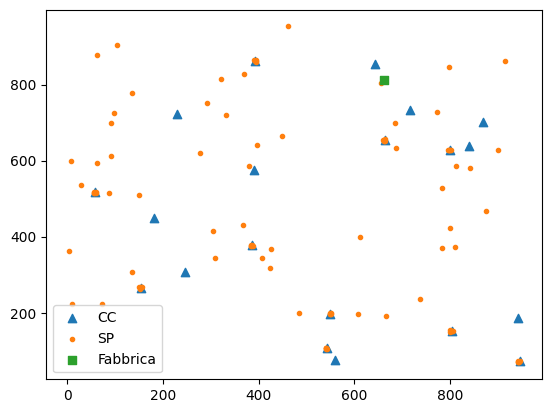

In [4]:
k=1000  #dimensioni della mappa (prima test con k=1000, poi varialo per studio domansionale)

n_SP=100   #number of source points
n_CC=20 #number of collection centers
n_cluster=int(0.5*n_CC)  #number of clusters
cluster_ratio=0.5  #how many of the total nodes (SPs and CCs) fall within a cluster

#RICORDATI DI COMMENTARE IL SEED PER MISURARE PERFORMANCE
np.random.seed(seed=420) #fissa il seed per riproducibilità nei test

P, S, biodiesel=data_generation(k, n_SP, n_CC, n_cluster, cluster_ratio)


#definizione e generazione delle altre costanti
alpha=1  #costo per unità di distanza
V=5 #numero massimo di veicoli, numero effettivamente utilizzato viene ottimizzato, 5 è una scelta 'sicura' probabilmente può essere ridotto per acellerare la soluzione 
Q=24  #numero di cestini su ogni veicolo
B=50  #capacità, in litri, dei bins sui veicoli
b=10  #costo di un bin
max_distance=300  #distanza massima fra un SP e un CC
R=1800 #lungezza massima percorso per veicolo, se distanza fra 0,0 e 1000,1000 è 1414 allora 1800 non è sufficiente nel caso il centrp biodiesel venga generato in un angolo?
P0=np.concatenate((P, biodiesel)) #set posizione biodiesel+CC (serve in calcoli veicoli)
f=np.random.randint(50, 150+1, size=(n_CC))  #costo per aprire il CC i
d_s=np.random.randint(1, 20+1, size=(len(S)))  #produzione settimanale in litri di olio del SP i
C=np.random.randint(1, 5+1, size=(n_CC))  #numero di Bins nel CC i


#P_s è il set dei CC entro la distanza di copertura dal SP s
#quindi per ogni SP creo lista P_s contente indice dei CC compatibili, poi salvo in lista di liste il tutto
P_s_list=[]  #inizializzo lista che conterrà i vari P_s
for s in range(len(S)):
    P_s=[]  #inizializzo P_s
    for i in range(len(P)): 
        if (distance(S[s], P[i])<300):   #controlla se la distanza è minore di 300
            P_s.append(i)  #se distanza e minore di 300 salva l'indice del CC compatibile
    P_s_list.append(P_s)  #aggiunge la lista alla lista totale


#crea matrice delle distanze fra elementi di P0, serve per funzione obbiettivo e constraints
c0=np.empty([len(P0), len(P0)])
for i in range(len(P0)):
    for j in range(len(P0)):
        c0[i,j]=distance(P0[i], P0[j])
        

#plot della mappa usa solo per creare immagine di esempio
#da migliorare dimensioni, ma dopo punti sembrano troppo sovrapposti...
plt.scatter(P[:,0], P[:,1], label="CC", marker="^")
plt.scatter(S[:,0], S[:,1], label="SP", marker=".")
plt.scatter(biodiesel[:,0], biodiesel[:,1], label="Fabbrica", marker=",")
plt.legend()
plt.show()

### Problem initialization and setting of objective function

In [5]:
#crea i set degli indici
P_set=range(0, n_CC) #CC
S_set=range(0, n_SP) #SP
P0_set=range(0, n_CC+1)  #CC+centro biodiesel (ultimo elemento)
V_set=range(0, V)  #veicoli

oil_model=gp.Model() #crea il modello
oil_model.modelSense = gp.GRB.MINIMIZE

#decision variables
#1 se il CC i viene aperto, 0 altrimenti
x_i=oil_model.addVars([(i) for i in P_set], vtype=gp.GRB.BINARY) 

#1 se il SP s viene assegnato al CC i, 0 altrimenti.
z_si=oil_model.addVars([(s, i) for s in S_set for i in P_s_list[s]], vtype=gp.GRB.BINARY) 

#1 se il veicolo k viaggia da i a j, 0 altrimenti
v_ijk=oil_model.addVars([(i, j, k) for i in P0_set for j in P0_set for k in V_set], vtype=gp.GRB.BINARY) 

#numero di bins raccolti dal veicolo k al CC i
t_ik=oil_model.addVars([(i, k) for i in P_set for k in V_set], lb=0, vtype=gp.GRB.INTEGER) 

#variabile ausiliaria per eliminazione dei subtours
u_i=oil_model.addVars([(i) for i in P_set], lb=0, vtype=gp.GRB.INTEGER) 


#objective function and constraints
#1)objective function
oil_model.setObjective(alpha*gp.quicksum(c0[i,j]*v_ijk[i,j,k] for i in P0_set for j in P0_set for k in V_set)+
                       gp.quicksum(f[i]*x_i[i] for i in P_set)+
                       b*gp.quicksum(t_ik[i,k] for i in P_set for k in V_set)
                      )

#2)ensure that the total amount of WCO generated by the SPs assigned to a CC is not higher than the 
#total capacity of the bins placed at that CC
oil_model.addConstrs(gp.quicksum(d_s[s]*z_si[s, i] for s in S_set if i in P_s_list[s])<=
                     B*gp.quicksum(t_ik[i,k] for k in V_set)
                     for i in P_set 
                    )

#3)limit the capacity of each CC in terms of the number of bins. These constraints also make sure that a CC must be opened if bins are
#placed at that CC.
oil_model.addConstrs(gp.quicksum(t_ik[i,k] for k in V_set)<=
                     C[i]*x_i[i]
                     for i in P_set 
                    )

#4)force a CC to be opened if an SP is assigned to it.
oil_model.addConstrs(z_si[s,i]<=
                     x_i[i]
                     for s in S_set for i in P_s_list[s] 
                    )    
#5)Each SP is assigned to one of the CCs within the coverage distance
oil_model.addConstrs(gp.quicksum(z_si[s,i] for i in P_s_list[s])==1 
                     for s in S_set  
                    )   

#6)guarantee that each vehicle leaves the biodiesel facility at most once.
#in questo caso il centro biodiesel è l'ultimo punto di P0, quindi questo constraint è leggermente diverso da quello nel paper
oil_model.addConstrs(gp.quicksum(v_ijk[len(P0)-1,i,k] for i in P_set)<=1
                     for k in V_set 
                    )    

#7)A collection vehicle can pick up bins at a CC only if it visits the CC
oil_model.addConstrs(t_ik[i,k]<=
                     Q*gp.quicksum(v_ijk[j,i,k] for j in P0_set if j!=i)
                     for i in P_set for k in V_set
                    )   

#8)total number of bins picked up by a vehicle cannot be greater than the vehicle capacity.
oil_model.addConstrs(gp.quicksum(t_ik[i,k] for i in P_set)<=
                     Q
                     for k in V_set
                    )

#9)route continuity constraints.
oil_model.addConstrs(gp.quicksum(v_ijk[i,j,k] for j in P0_set)==
                     gp.quicksum(v_ijk[j,i,k] for j in P0_set)
                     for i in P0_set for k in V_set
                    )  

#10)ensure that a vehicle is routed through a CC if and only if that CC is opened.
oil_model.addConstrs(gp.quicksum(v_ijk[i,j,k] for j in P0_set for k in V_set if j!=i)==
                     x_i[i]
                     for i in P_set
                    )  

#11)ensure that a vehicle is routed through a CC if and only if that CC is opened.
oil_model.addConstrs(gp.quicksum(v_ijk[j,i,k] for j in P0_set for k in V_set if j!=i)==
                     x_i[i]
                     for i in P_set 
                    )  

#12)eliminates subtours
oil_model.addConstrs(u_i[i]-u_i[j]+len(P_set)*gp.quicksum(v_ijk[i,j,k] for k in V_set)<=
                     len(P_set)-1
                     for i in P_set for j in P_set if i!=j
                    )  

#13)restrict the travel distance of each route by the maximum route duration.
oil_model.addConstrs(gp.quicksum(c0[i,j]*v_ijk[i,j,k] for i in P0_set for j in P0_set)<=
                     R
                     for k in V_set
                    )  

#14-18) sono gia definiti implicitamente nella inizializzazione delle decision variables


#update del modello per aggiunger la funzione obbiettivo e i constraints
oil_model.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-26


### Solving and solution access

In [6]:
oil_model.setParam('TimeLimit', 7200)  #set tempo massimo ricerca soluzione...
oil_model.optimize()

Set parameter TimeLimit to value 7200
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen 3 3250U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1279 rows, 2844 columns and 17516 nonzeros
Model fingerprint: 0xb30e6f92
Variable types: 0 continuous, 2844 integer (2724 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 32 rows and 109 columns
Presolve time: 0.04s
Presolved: 1247 rows, 2735 columns, 17374 nonzeros
Variable types: 0 continuous, 2735 integer (2625 binary)

Root relaxation: objective 1.494709e+03, 1094 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1494.

 49116 10750 infeasible   51      3671.00000 3048.50643  17.0%  70.1  300s
 50545 11211 3081.05141   50  289 3671.00000 3055.84433  16.8%  70.3  305s
 51461 11485 3549.15000   56   22 3671.00000 3060.19130  16.6%  70.5  310s
 52820 11939 3613.37500   59   68 3671.00000 3065.34364  16.5%  70.7  315s
 53978 12335 3188.35122   48  132 3671.00000 3070.15000  16.4%  70.7  320s
 55683 12821 3168.43182   45  138 3671.00000 3077.01230  16.2%  70.7  326s
 56946 13165 3599.10000   47   65 3671.00000 3081.61774  16.1%  70.8  330s
 58529 13585 3261.98889   44   83 3671.00000 3087.70969  15.9%  70.8  336s
 58981 13654 3371.83176   43  183 3671.00000 3089.60000  15.8%  70.8  348s
 59221 13657 3590.42105   48  106 3671.00000 3089.60000  15.8%  70.8  353s
 59611 13882 3256.36667   53  101 3671.00000 3090.33984  15.8%  70.8  356s
 61022 14241 3291.51394   44  253 3671.00000 3098.57714  15.6%  70.9  360s
 62383 14631 3380.06667   53  134 3671.00000 3102.47597  15.5%  71.1  365s
 63834 14917 3636.03666  

 193724 30933     cutoff   57      3671.00000 3361.44167  8.43%  68.6  851s
 194936 30953 3623.00851   56  156 3671.00000 3363.09800  8.39%  68.5  856s
 195837 30975 3661.86667   52   18 3671.00000 3363.82509  8.37%  68.5  860s
 197030 30988 3407.23636   60  119 3671.00000 3365.65000  8.32%  68.4  865s
 198798 30960 3514.73333   50   56 3671.00000 3367.77500  8.26%  68.3  871s
 199792 30926 3479.52500   58   58 3671.00000 3369.27500  8.22%  68.3  875s
 201450 30841 3611.86738   59   75 3671.00000 3371.52500  8.16%  68.2  881s
 202308 30781 3505.58333   49   56 3671.00000 3373.20000  8.11%  68.2  885s
 204189 30787 infeasible   45      3671.00000 3375.55000  8.05%  68.2  891s
 205655 30721 3436.16667   78   48 3671.00000 3378.00734  7.98%  68.1  896s
 206925 30622     cutoff   64      3671.00000 3380.00000  7.93%  68.1  901s
 208315 30605 3567.97146   64  240 3671.00000 3381.88750  7.88%  68.0  905s
 209746 30558 3637.18000   71   76 3671.00000 3383.80000  7.82%  68.0  911s
 211176 3053

 339859  3205 3635.60000   58   76 3671.00000 3605.22731  1.79%  61.6 1390s
 342172  1575     cutoff   58      3671.00000 3622.80000  1.31%  61.4 1396s
 343268  1048     cutoff   51      3671.00000 3629.30000  1.14%  61.3 1400s

Cutting planes:
  Learned: 6
  Gomory: 7
  Cover: 382
  Implied bound: 123
  Projected implied bound: 2
  MIR: 187
  StrongCG: 14
  Flow cover: 436
  GUB cover: 2
  Inf proof: 142
  Zero half: 322
  RLT: 162
  Relax-and-lift: 6

Explored 344698 nodes (21072643 simplex iterations) in 1404.50 seconds (1353.87 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 3671 3819 4006 ... 5837

Optimal solution found (tolerance 1.00e-04)
Best objective 3.671000000000e+03, best bound 3.671000000000e+03, gap 0.0000%


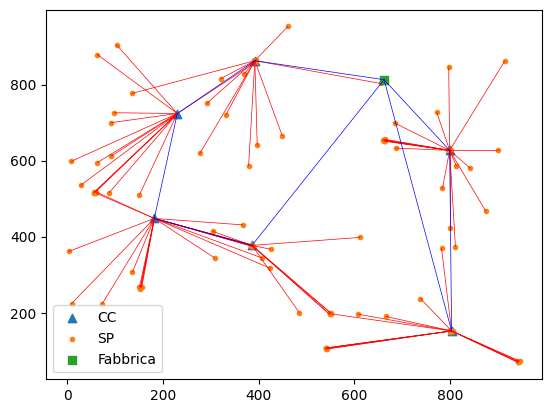

In [17]:
oil_model.write('model.mps') #per salvare il modello trovato
#accesso soluzioni
opened_CC=oil_model.getAttr('x', x_i)
connected_SP=oil_model.getAttr('x', z_si)
vehicle_route=oil_model.getAttr('x', v_ijk)
#t_ik=oil_model.getAttr('x', t_ik)

#per estrarre i CC aperti
P_open=[]
for i in P_set:
    if (opened_CC[i]==1):
        P_open.append(P[i])
P_open=np.concatenate([P_open]) #mette il tutto in un unico np.array

#per estrarre le coppie CC-SP
CC_SP=[]
for s in S_set:
    for i in P_s_list[s]:
        if (connected_SP[s,i]==1):
            CC_SP.append(([S[s]],[P[i]]))
#mette il tutto in due array            
SP_coord=np.concatenate([i[0] for i in CC_SP])
CC_coord=np.concatenate([i[1] for i in CC_SP])

#per estrarre la route
route=[]
for i in P0_set:
    for j in P0_set:
        for k in V_set:
            if (vehicle_route[i,j,k]==1):
                route.append(([P0[i]],[P0[j]],[k]))
#mette il tutto in tre array            
route_coord1=np.concatenate([i[0] for i in route])
route_coord2=np.concatenate([i[1] for i in route])
vehicle_number=np.concatenate([i[2] for i in route])

#plot
plt.scatter(P_open[:,0], P_open[:,1], label="CC", marker="^")
plt.scatter(S[:,0], S[:,1], label="SP", marker=".")
plt.scatter(biodiesel[:,0], biodiesel[:,1], label="Fabbrica", marker=",")
plt.plot([SP_coord[:,0], CC_coord[:,0]], [SP_coord[:,1], CC_coord[:,1]], color='red', linewidth=0.5)#plotta collegamenti fra CC e SP
plt.plot([route_coord1[:,0], route_coord2[:,0]], [route_coord1[:,1], route_coord2[:,1]], linewidth=0.5, color='blue')#plotta le route
plt.legend()
plt.show()